In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import joblib

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-komputer-if3170/data_train.csv
/kaggle/input/data-komputer-if3170/data_validation.csv


# Setup

In [2]:
train_df = pd.read_csv("/kaggle/input/data-komputer-if3170/data_train.csv")
train_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,804,1,0.8,1,12,1,41,0.9,89,1,...,709,818,2027,11,5,11,1,0,0,1
1,1042,0,2.2,0,15,1,11,0.6,139,5,...,68,1018,2826,18,0,2,1,0,0,2
2,1481,1,2.0,1,0,0,35,0.5,105,3,...,249,522,2635,17,16,4,1,0,1,2
3,1104,0,1.7,0,1,1,60,0.4,199,2,...,653,1413,1229,6,0,3,1,1,1,0
4,652,0,0.5,1,1,0,58,0.6,142,3,...,464,781,565,18,12,9,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,536,1,1.4,0,0,1,53,0.7,135,3,...,547,705,1211,15,10,7,1,0,1,0
1396,1097,0,0.8,0,10,1,21,0.1,160,7,...,1277,1352,2219,15,6,12,1,0,1,2
1397,1179,1,0.5,0,7,1,32,0.3,182,2,...,85,1451,340,16,5,16,1,0,0,0
1398,719,1,0.5,1,0,1,23,0.4,113,6,...,431,1727,3990,14,9,12,1,1,1,3


In [3]:
validation_df = pd.read_csv("/kaggle/input/data-komputer-if3170/data_validation.csv")
validation_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
2,769,1,2.9,1,0,0,9,0.1,182,5,...,248,874,3946,5,2,7,0,0,0,3
3,775,0,1.0,0,3,0,46,0.7,159,2,...,862,1864,568,17,15,11,1,1,1,0
4,595,0,0.9,1,7,1,23,0.1,121,3,...,441,810,3752,10,2,18,1,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1547,1,2.9,0,2,0,57,0.4,114,1,...,347,957,1620,9,2,19,0,1,1,1
596,1882,0,2.0,0,11,1,44,0.8,113,8,...,4,743,3579,19,8,20,1,1,0,3
597,674,1,2.9,1,1,0,21,0.2,198,3,...,576,1809,1180,6,3,4,1,1,1,0
598,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2


In [4]:
non_numeric_columns = ["blue", "wifi", "touch_screen", "three_g", "four_g", "dual_sim"]
drop_col = non_numeric_columns.copy()
drop_col.append("price_range")
numeric_columns = train_df.drop(drop_col, axis=1).columns.tolist()

numeric_columns.remove("fc")

# Data Preprocessing
Dari analisis EDA yang dilakukan akan dilakukan data preprocessing untuk melakukan pelatihan model

## Removing Outliers

Remove outliers using IQR

In [5]:
class OutlierRemoval(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
        
    def fit(self, X, y = None):
        q3 = X['fc'].quantile(q=0.75)
        q1 = X['fc'].quantile(q=0.25)
        self.IQR = q3-q1
        self.lower_bound = q1 - 1.5 * self.IQR
        self.upper_bound = q3 + 1.5 * self.IQR
        return self
    
    def transform(self, X):
        X_ = X[(X.loc[:,"fc"] >= self.lower_bound) & (X.loc[:,"fc"]<=self.upper_bound)]
        return X_

## Invalid Data Filling

Invalid data will be filled with median using interpolation

In [6]:
class InvalidReplacement(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        self.median = X['sc_w'].median()
        return self
    
    def transform(self, X):
        X_ = X.copy()
        X_['sc_w'] = X_['sc_w'].replace(0, self.median)
        return X_

## Feature Selection
Remove fc column because it correlates the highest with pc

In [7]:
class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.drop(columns = self.column)
        return X_

## Scaling and Normalizing
Scale values of numeric columns minus column`fc`

In [8]:
numericTransformation = ColumnTransformer(
    transformers = [
#         ('scaling', MinMaxScaler(), numeric_columns)
        ('normalizing', Normalizer(), numeric_columns)
    ],
    remainder = 'passthrough'
)

## Pipeline
Pipeline for all preprocessing

In [9]:
pipeline = Pipeline([
    ('removing outliers', OutlierRemoval()),
    ('invalid data replacement', InvalidReplacement()),
    ('feature selection', DropColumn('fc'))
])

full_pipeline = Pipeline([
    ('preprocessor', pipeline),
    ('scaling', numericTransformation)
])

transformed_column_names = numeric_columns + [col for col in train_df.columns if col not in numeric_columns and col != 'fc']
processed_data = full_pipeline.fit_transform(train_df)
print(processed_data.shape)
processed_df = pd.DataFrame(processed_data, columns = transformed_column_names)

(1389, 20)


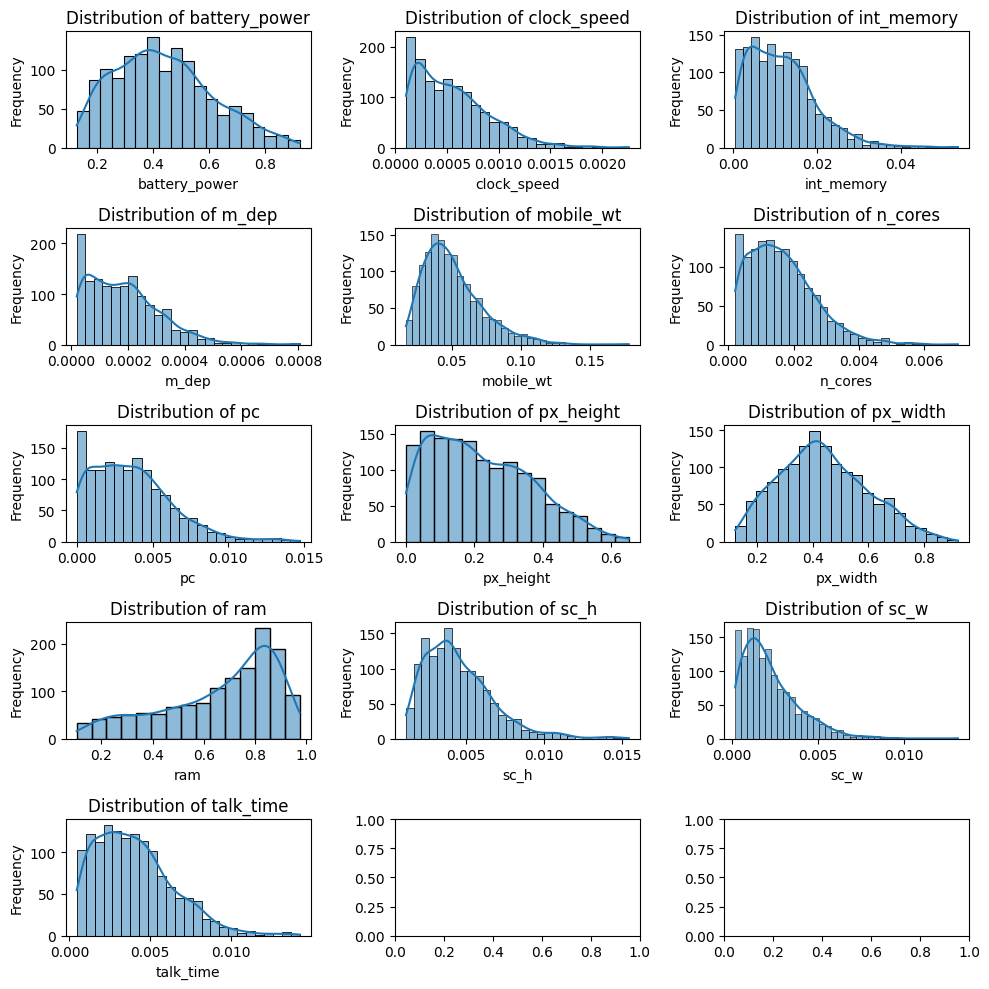

In [10]:
fig, ax = plt.subplots(5, 3, figsize = (10,10))

for i, col in enumerate(numeric_columns):
    r = i // 3
    c = i % 3
    
    sns.histplot(kde=True,data=processed_df[col], ax=ax[r,c])    
    ax[r, c].set_title(f'Distribution of {col}')
    ax[r, c].set_xlabel(col)
    ax[r, c].set_ylabel("Frequency")
    
plt.tight_layout()
plt.show()

# Modelling

In [11]:
target_column = processed_df['price_range']
feature_column = processed_df.drop(columns=['price_range'])
feature_column

,battery_power,clock_speed,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,blue,dual_sim,four_g,three_g,touch_screen,wifi
0,0.329969,0.000328,0.016827,0.000369,0.036526,0.000410,0.005335,0.290980,0.335715,0.831899,0.004514,0.002052,0.004514,1.0,1.0,1.0,1.0,0.0,0.0
1,0.327339,0.000691,0.003456,0.000188,0.043666,0.001571,0.005026,0.021362,0.319799,0.887772,0.005655,0.001571,0.000628,0.0,0.0,1.0,1.0,0.0,0.0
2,0.480908,0.000649,0.011365,0.000162,0.034095,0.000974,0.000000,0.080855,0.169503,0.855632,0.005520,0.005195,0.001299,1.0,1.0,0.0,1.0,0.0,1.0
3,0.484337,0.000746,0.026323,0.000175,0.087304,0.000877,0.005703,0.286478,0.619899,0.539176,0.002632,0.002194,0.001316,0.0,0.0,1.0,1.0,1.0,1.0
4,0.516473,0.000396,0.045944,0.000475,0.112483,0.002376,0.001584,0.367551,0.618658,0.447557,0.014258,0.009506,0.007129,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,0.334252,0.000873,0.033051,0.000437,0.084187,0.001871,0.000000,0.341112,0.439641,0.755185,0.009354,0.006236,0.004365,1.0,0.0,1.0,1.0,0.0,1.0
1385,0.353821,0.000258,0.006773,0.000032,0.051606,0.002258,0.004838,0.411877,0.436067,0.715705,0.004838,0.001935,0.003870,0.0,0.0,1.0,1.0,0.0,1.0
1386,0.616855,0.000262,0.016742,0.000157,0.095223,0.001046,0.006278,0.044472,0.759166,0.177889,0.008371,0.002616,0.008371,1.0,0.0,1.0,1.0,0.0,0.0
1387,0.162326,0.000113,0.005193,0.000090,0.025512,0.001355,0.002032,0.097305,0.389899,0.900808,0.003161,0.002032,0.002709,1.0,1.0,1.0,1.0,1.0,1.0


In [12]:
scaling_test = numericTransformation.fit_transform(validation_df.drop(columns="fc"))

transformed_column_names = numeric_columns + [col for col in train_df.columns if col not in numeric_columns and col != 'fc']

scaled_test = pd.DataFrame(scaling_test, columns = transformed_column_names)

y_test = scaled_test['price_range']
X_test = scaled_test.drop(columns="price_range")

In [13]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

## Using Scikit KNN

### Model

In [14]:
scikit_knn = KNeighborsClassifier(n_neighbors = 5)
scikit_knn.fit(feature_column, target_column)

KNeighborsClassifier()

### Prediction

In [15]:
y_pred = scikit_knn.predict(X_test)
y_pred

array([3., 1., 3., 1., 3., 2., 3., 1., 1., 2., 3., 0., 0., 1., 2., 0., 1.,
       1., 0., 2., 1., 1., 1., 0., 1., 2., 2., 2., 2., 2., 1., 3., 3., 3.,
       2., 3., 3., 2., 1., 1., 1., 3., 0., 1., 1., 0., 1., 3., 1., 1., 3.,
       3., 3., 0., 2., 2., 2., 1., 2., 1., 1., 3., 3., 1., 2., 2., 2., 2.,
       0., 2., 1., 3., 2., 0., 3., 2., 0., 2., 1., 0., 3., 2., 1., 1., 3.,
       0., 3., 2., 1., 3., 0., 2., 0., 3., 1., 0., 3., 3., 2., 2., 3., 1.,
       0., 2., 2., 2., 3., 2., 2., 1., 1., 2., 3., 2., 3., 1., 1., 3., 0.,
       2., 1., 3., 1., 3., 1., 3., 2., 3., 1., 3., 2., 2., 1., 0., 2., 0.,
       0., 0., 3., 1., 1., 2., 3., 1., 3., 3., 0., 2., 3., 3., 3., 1., 0.,
       2., 0., 0., 2., 0., 0., 3., 3., 1., 1., 1., 3., 0., 2., 1., 0., 3.,
       3., 0., 1., 0., 1., 1., 3., 0., 2., 0., 2., 3., 1., 3., 0., 3., 0.,
       2., 3., 0., 1., 3., 0., 1., 2., 1., 2., 3., 3., 0., 1., 3., 2., 3.,
       1., 3., 3., 3., 0., 3., 1., 3., 3., 0., 3., 1., 1., 0., 0., 2., 2.,
       1., 1., 1., 0., 3.

### Evaluation

In [16]:
knn_mse = mean_squared_error(y_test, y_pred)
knn_mse = np.sqrt(knn_mse) 
knn_mse

1.0723805294763609

In [17]:
knn_scores = cross_val_score(scikit_knn, feature_column, target_column, scoring="neg_mean_squared_error", cv=10)
knn_rmse_scores = np.sqrt(-knn_scores)
display_scores(knn_rmse_scores)

Scores: [1.06615695 1.03534653 1.00716855 0.92136902 1.08951841 1.06615695
 1.00716855 1.04571754 0.92914442 0.92077472]
Mean: 1.008852164728546
Standard deviation: 0.06075002798512403


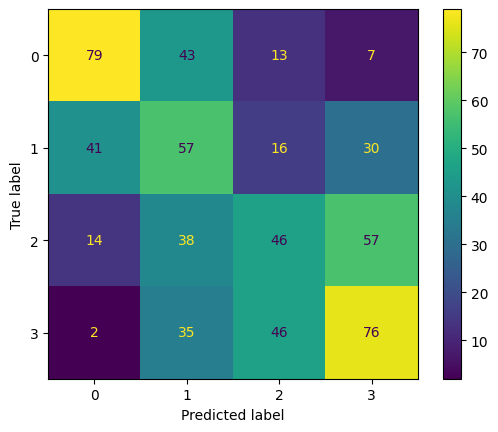

In [18]:
knn_cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(knn_cm)
disp.plot()
plt.show()

### Saving Model

In [19]:
joblib.dump(scikit_knn, "/kaggle/working/scikit_knn.pkl")

['/kaggle/working/scikit_knn.pkl']

## Using Scikit Naive Bayes

### Model

In [20]:
scikit_nb = GaussianNB()
scikit_nb.fit(feature_column, target_column)

GaussianNB()

### Prediction

In [21]:
y_pred_nb = scikit_nb.predict(X_test)
y_pred_nb

array([2., 2., 3., 0., 3., 1., 3., 0., 3., 1., 3., 2., 3., 1., 3., 0., 1.,
       1., 0., 3., 2., 1., 0., 0., 1., 0., 2., 1., 0., 2., 1., 3., 3., 0.,
       2., 3., 2., 2., 2., 1., 1., 3., 1., 2., 2., 1., 1., 3., 1., 2., 2.,
       2., 3., 0., 1., 3., 2., 3., 3., 2., 2., 3., 3., 1., 3., 2., 2., 2.,
       3., 3., 2., 3., 2., 0., 1., 3., 0., 3., 1., 0., 2., 3., 0., 2., 3.,
       1., 3., 3., 0., 3., 1., 1., 1., 3., 1., 1., 3., 2., 0., 2., 2., 2.,
       1., 3., 2., 1., 3., 3., 3., 3., 3., 3., 3., 2., 3., 1., 1., 3., 1.,
       3., 1., 3., 2., 3., 3., 0., 2., 2., 1., 3., 3., 2., 0., 0., 3., 1.,
       1., 2., 3., 0., 1., 3., 3., 1., 2., 2., 1., 2., 1., 2., 3., 0., 0.,
       2., 1., 1., 3., 1., 1., 3., 3., 3., 1., 2., 3., 0., 1., 1., 0., 2.,
       3., 1., 0., 1., 1., 1., 3., 0., 2., 0., 3., 1., 1., 2., 0., 2., 0.,
       3., 2., 0., 3., 3., 0., 0., 2., 1., 1., 3., 3., 1., 2., 2., 2., 3.,
       2., 3., 3., 3., 0., 3., 1., 2., 3., 1., 2., 3., 3., 0., 0., 2., 2.,
       3., 2., 3., 0., 3.

### Evaluation

In [22]:
nb_mse = mean_squared_error(y_test, y_pred_nb)
nb_mse = np.sqrt(nb_mse) 
nb_mse

0.5291502622129182

In [23]:
nb_scores = cross_val_score(scikit_nb, feature_column, target_column, scoring="neg_mean_squared_error", cv=10)
nb_rmse_scores = np.sqrt(-nb_scores)
display_scores(nb_rmse_scores)

Scores: [0.49457488 0.50891336 0.56262489 0.54968925 0.53644178 0.54968925
 0.49457488 0.59373225 0.53644178 0.47395958]
Mean: 0.5300641906574455
Standard deviation: 0.034755605511003866


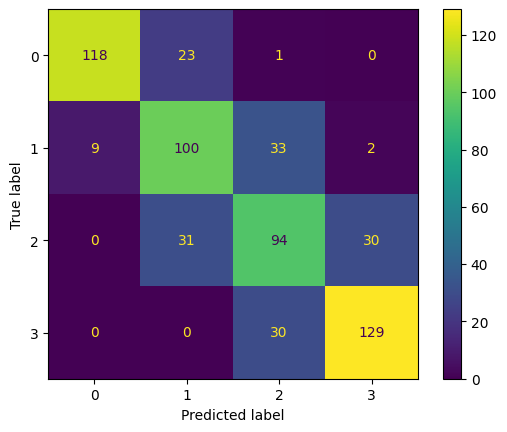

In [24]:
nb_cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(nb_cm)
disp.plot()
plt.show()

### Saving Model

In [25]:
joblib.dump(scikit_nb, "/kaggle/working/scikit_naive_bayes.pkl")

['/kaggle/working/scikit_naive_bayes.pkl']

# Submission

In [26]:
submit_nb_scikit =  pd.DataFrame(y_pred_nb, index=X_test.index, columns=["price_range"])
submit_nb_scikit

,price_range
0,2.0
1,2.0
2,3.0
3,0.0
4,3.0
...,...
595,1.0
596,2.0
597,1.0
598,1.0
